<a href="https://colab.research.google.com/github/Leostark95/Proyecto_Competencia_Kaggle/blob/main/03%20-%20logistic%20regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='056938'> Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy
import math
import os
import zipfile
import joblib
import warnings

warnings.filterwarnings("ignore")

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# <font color='056938'> Selección de características

In [2]:
df = pd.read_pickle('/content/drive/MyDrive/IA 2024-1/Competencia Kaggle/preprocessed_train.pkl')

<Axes: >

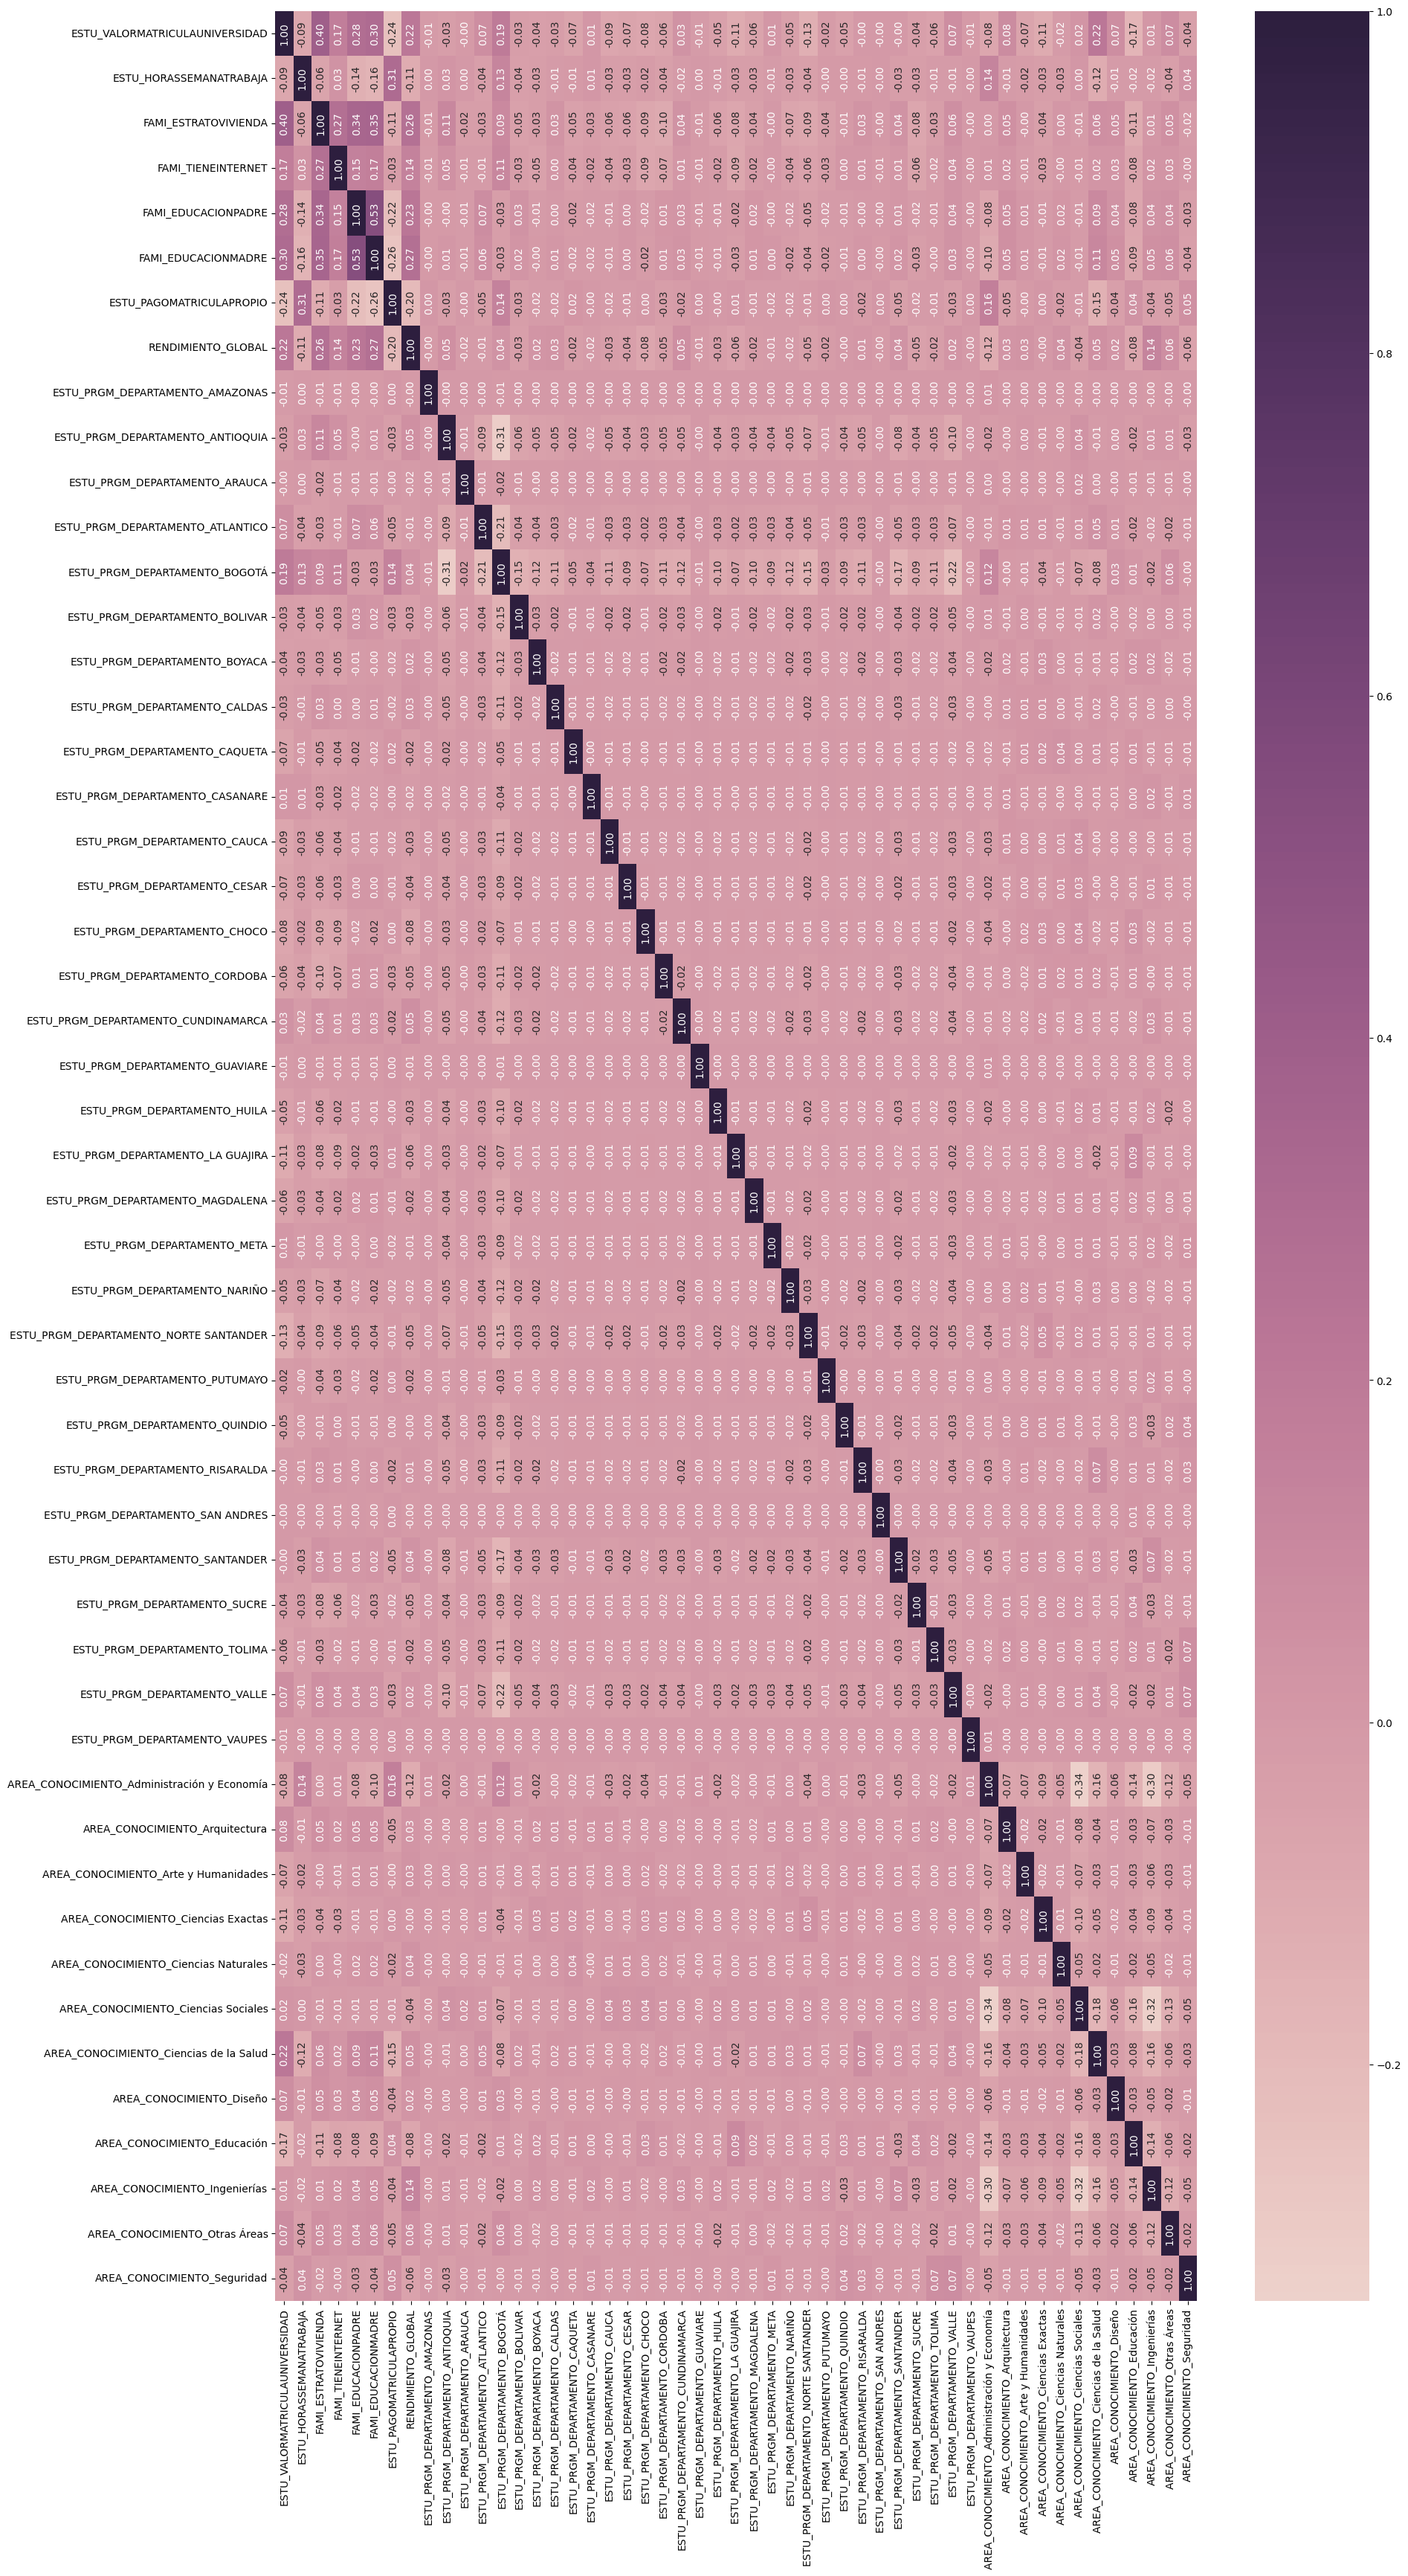

In [3]:
plt.figure(figsize=(20,40))
sns.heatmap(
    df.corr(),
    cmap=sns.cubehelix_palette(as_cmap=True),
    annot=True,
    fmt=".2f",
    annot_kws={"rotation": 90}  # Rotar los valores anotados 90 grados
)

## <font color='157699'> Selección de Características por Métodos de Ensamble

In [4]:
# Separar las características (X) y la variable objetivo (y)
X = df.drop(columns=['RENDIMIENTO_GLOBAL'])
y = df['RENDIMIENTO_GLOBAL']

In [5]:
# Tomar una muestra del dataset
sample_df = df.sample(frac=0.9, random_state=42)
X_sample = sample_df.drop(columns=['RENDIMIENTO_GLOBAL'])
y_sample = sample_df['RENDIMIENTO_GLOBAL']

In [6]:
# Modelo Random Forest para obtener la importancia de las características
rf_model = RandomForestClassifier(n_estimators=150, random_state=42)
rf_model.fit(X_sample, y_sample)

# Importancia de las características
feature_importances = rf_model.feature_importances_

# DataFrame con la importancia de cada característica
feature_importance_df = pd.DataFrame({
    'Feature': X_sample.columns,
    'Importance': feature_importances
})

# Ordenar las características por importancia de mayor a menor
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


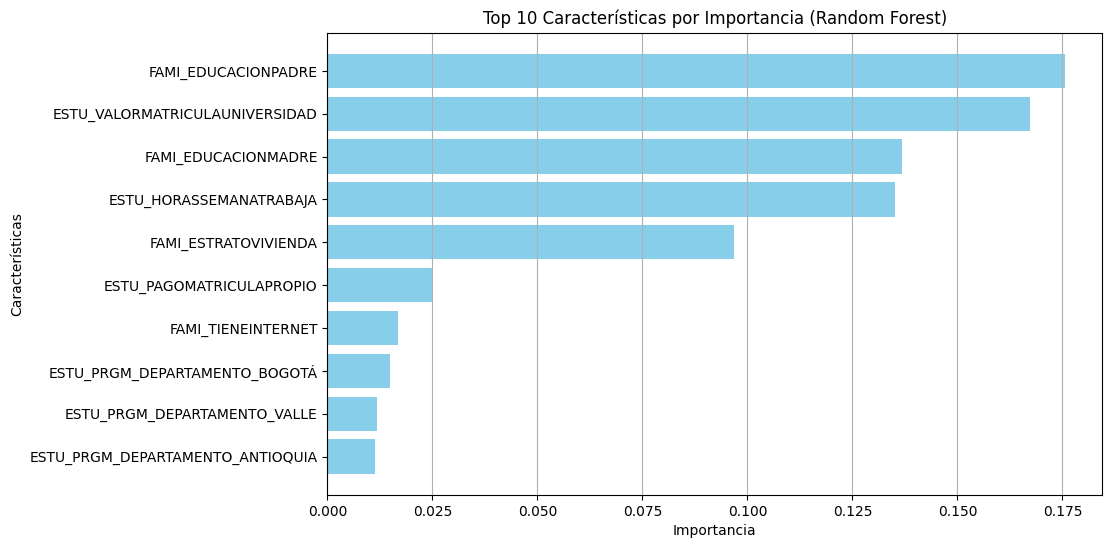

                             Feature  Importance
4                FAMI_EDUCACIONPADRE    0.175715
0     ESTU_VALORMATRICULAUNIVERSIDAD    0.167357
5                FAMI_EDUCACIONMADRE    0.136886
1            ESTU_HORASSEMANATRABAJA    0.135013
2               FAMI_ESTRATOVIVIENDA    0.096688
6           ESTU_PAGOMATRICULAPROPIO    0.025102
3                 FAMI_TIENEINTERNET    0.016729
11     ESTU_PRGM_DEPARTAMENTO_BOGOTÁ    0.014877
36      ESTU_PRGM_DEPARTAMENTO_VALLE    0.011857
8   ESTU_PRGM_DEPARTAMENTO_ANTIOQUIA    0.011425


In [24]:
# Visualizar las 51 características totales
top_features = feature_importance_df.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.title("Top 10 Características por Importancia (Random Forest)")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

print(top_features)


## <font color='157699'> Selección de Características por Métodos de Filtrado

In [8]:
# Escalar las características al rango [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Aplicar el test de chi-cuadrado
chi2_selector = SelectKBest(score_func=chi2, k=20)
X_kbest = chi2_selector.fit_transform(X_scaled, y)

# Obtener las puntuaciones del test de chi-cuadrado
chi2_scores = chi2_selector.scores_

# Crear un DataFrame con las puntuaciones
chi2_results = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Score': chi2_scores
})

# Ordenar las características por puntuación de chi-cuadrado
chi2_results = chi2_results.sort_values(by='Chi2 Score', ascending=False)

# Mostrar las 10 mejores características
top_chi2_features = chi2_results.head(10)
print(top_chi2_features)

                                        Feature    Chi2 Score
6                      ESTU_PAGOMATRICULAPROPIO  15786.532906
47                AREA_CONOCIMIENTO_Ingenierías  10192.537781
38  AREA_CONOCIMIENTO_Administración y Economía   7839.929112
19                 ESTU_PRGM_DEPARTAMENTO_CHOCO   5854.582918
46                  AREA_CONOCIMIENTO_Educación   5159.999472
0                ESTU_VALORMATRICULAUNIVERSIDAD   4550.685599
5                           FAMI_EDUCACIONMADRE   4423.346354
4                           FAMI_EDUCACIONPADRE   4244.471117
2                          FAMI_ESTRATOVIVIENDA   4075.561792
1                       ESTU_HORASSEMANATRABAJA   3077.538666


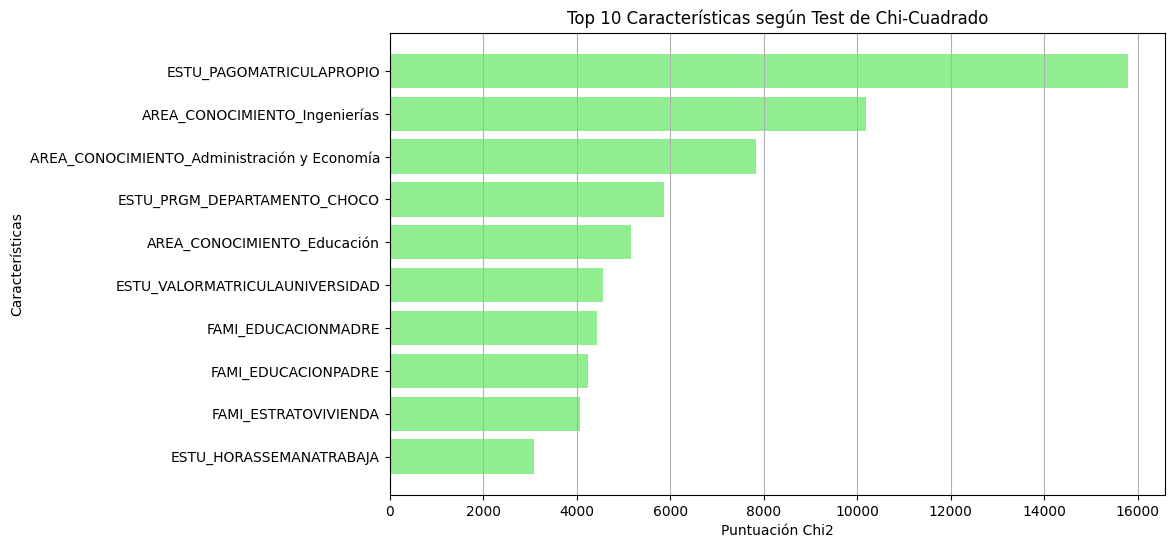

In [10]:
plt.figure(figsize=(10, 6))
plt.barh(top_chi2_features['Feature'], top_chi2_features['Chi2 Score'], color='lightgreen')
plt.title("Top 10 Características según Test de Chi-Cuadrado")
plt.xlabel("Puntuación Chi2")
plt.ylabel("Características")
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

## <font color='157699'> Selección de Características por Métodos Wrapper (De emboltura)



In [11]:
# Agregar una columna de intercepto
X = sm.add_constant(X)

In [12]:
def backward_elimination(X, y, significance_level=0.05):
    features = list(X.columns)
    while len(features) > 0:
        # Crear el modelo OLS (Ordinary Least Squares)
        model = sm.OLS(y, X[features]).fit()
        # Obtener el valor p para cada característica
        p_values = model.pvalues
        # Encontrar la característica con el valor p más alto
        max_p_value = p_values.max()
        if max_p_value > significance_level:
            # Eliminar la característica con el valor p más alto
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
            print(f"Eliminando {excluded_feature} con p-value {max_p_value}")
        else:
            break
    # Retornar las características seleccionadas
    selected_features = features
    print("Características seleccionadas:", selected_features)
    return selected_features


In [13]:
selected_features = backward_elimination(X, y)
print("Características finales seleccionadas:", selected_features)


Eliminando ESTU_PRGM_DEPARTAMENTO_MAGDALENA con p-value 0.7803867190624145
Eliminando ESTU_PRGM_DEPARTAMENTO_AMAZONAS con p-value 0.7964912194601825
Eliminando ESTU_PRGM_DEPARTAMENTO_GUAVIARE con p-value 0.6101746729329451
Eliminando ESTU_PRGM_DEPARTAMENTO_NORTE SANTANDER con p-value 0.39050682818478966
Eliminando ESTU_PRGM_DEPARTAMENTO_SAN ANDRES con p-value 0.37895392305976083
Eliminando ESTU_PRGM_DEPARTAMENTO_CAQUETA con p-value 0.22017173176559657
Eliminando ESTU_PRGM_DEPARTAMENTO_META con p-value 0.2761429215766912
Eliminando AREA_CONOCIMIENTO_Diseño con p-value 0.15378337870368708
Eliminando ESTU_PRGM_DEPARTAMENTO_VAUPES con p-value 0.10309765962186884
Eliminando AREA_CONOCIMIENTO_Ciencias de la Salud con p-value 0.06375455860643166
Eliminando AREA_CONOCIMIENTO_Arquitectura con p-value 0.1908831134694233
Características seleccionadas: ['const', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA', 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE', 'FAMI_E

# <font color='056938'> Datos a utilizar

## <font color='157699'> Características seleccionadas


In [14]:
# Seleccionar las 14 características y la variable objetivo
features = [
    'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA', 'FAMI_ESTRATOVIVIENDA',
    'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE', 'ESTU_PAGOMATRICULAPROPIO',
    'ESTU_PRGM_DEPARTAMENTO_ANTIOQUIA', 'ESTU_PRGM_DEPARTAMENTO_BOGOTÁ', 'ESTU_PRGM_DEPARTAMENTO_VALLE',
    'AREA_CONOCIMIENTO_Ingenierías', 'AREA_CONOCIMIENTO_Administración y Economía',
    'AREA_CONOCIMIENTO_Educación', 'AREA_CONOCIMIENTO_Seguridad']

## <font color='157699'> Preparación y división de datos

In [15]:
X = df[features]
y = df['RENDIMIENTO_GLOBAL']

In [16]:
# Dividir el dataset en entrenamiento y validación (80%-20%)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# <font color='056938'> Regresión Logística

In [17]:
# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [18]:
# Definir y entrenar el modelo de regresión logística
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [19]:
# Predicciones en el conjunto de validación
y_pred = logreg_model.predict(X_valid_scaled)

# Calcular accuracy
accuracy = accuracy_score(y_valid, y_pred)
print(f"Accuracy del modelo Logistic Regression: {accuracy:.4f}")

# Validación cruzada con 5 folds
cv_scores = cross_val_score(logreg_model, X_train_scaled, y_train, cv=10, scoring='accuracy')
print(f"Accuracy promedio (cross-validation): {cv_scores.mean():.4f}")


Accuracy del modelo Logistic Regression: 0.3725
Accuracy promedio (cross-validation): 0.3692


# <font color='056938'> Regresión Logística con optimización de hiperparámetros

In [20]:
logreg = LogisticRegression(max_iter=1000,
                            random_state=42
)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(estimator=logreg,
                           param_grid=param_grid,
                           cv=5, scoring='accuracy',
                           n_jobs=-1,
                           verbose=2
)

In [21]:
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga', 'lbfgs']},
             scoring='accuracy', verbose=2)

In [22]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores hiperparámetros:", best_params)
print("Mejor accuracy promedio (cross-validation):", best_score)

Mejores hiperparámetros: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Mejor accuracy promedio (cross-validation): 0.36929963898916973


In [23]:
best_model = grid_search.best_estimator_
y_pred_optimized = best_model.predict(X_valid_scaled)
accuracy_optimized = accuracy_score(y_valid, y_pred_optimized)

print(f"Accuracy del modelo optimizado en el conjunto de validación: {accuracy_optimized:.4f}")

Accuracy del modelo optimizado en el conjunto de validación: 0.3725
